### This notebook generates the moisture-precip joint distributions for MCSs in the reanalysis-convective tracking data. First import libraries and constants.

In [1]:
import numpy as np
import scipy as sp
import xarray as xr
import matplotlib.pyplot as plt
import pandas as pd
import warnings
import numpy.ma as ma
import seaborn as sns
import scipy.optimize
from matplotlib import cm
from numpy import unravel_index

plt.rcParams.update({'font.size': 12})

warnings.filterwarnings(action='ignore')

from plotting_utilities import *
from thermodynamic_functions import *

In [2]:
g = 9.8 # gravitational acceleration [m s-2]
rho_air = 1.395 # density of air (kg m-3)
rho_water = 1000 #density of water (kg m-3)
eps = 0.01802/0.02897 # ratio of MW_water to MW_air

In [3]:
# array of years
years = np.arange( 1983, 2008 )

# create list of file names
file_years = file_concatenator(years)

# Are we only looking at tropical MCSs?
minlat_array = nc_open_compile(file_years,"min latitude")
print(np.nanmin(minlat_array))
maxlat_array = nc_open_compile(file_years,"max latitude")
print(np.nanmax(maxlat_array))
tropical_indx = np.argwhere( (minlat_array >= -30) & (maxlat_array <= 30) )[:,0]
print(tropical_indx.shape)

# applying same for MCS lifetime and morphology
lifetime_array = nc_open_compile(file_years,"lifetime")
lifetime_ERAI = negative_to_nan(lifetime_array)[tropical_indx]
maxrad_array = nc_open_compile(file_years,"maxrad")
maxrad_ERAI = negative_to_nan(maxrad_array)[tropical_indx]
minctt_array = nc_open_compile(file_years,"minctt")
minctt_ERAI = negative_to_nan(minctt_array)[tropical_indx]

-56.0
56.0
(695667,)


In [4]:
# applying same for pmax and pacc
pmax_array = nc_open_compile(file_years,"pmax")
pmax_ERAI = negative_to_nan(pmax_array)[tropical_indx]
pacc_array = nc_open_compile(file_years,"pacc")
pacc_ERAI = negative_to_nan(pacc_array)[tropical_indx]*3600 # convert to m3 / h

# extract pressure from the data files
# water vapour levels opened and vstacked, negatives removed
qv_array = nc_open_compile( file_years, "qv", 'stack' )
qv_ERAI = negative_to_nan(qv_array)[tropical_indx]

#pressure level values converted into double point precision
#factor of 100 converts hPa to Pa. we want to use SI units exclusively below.
plev_ERAI = np.double((xr.open_dataset(file_years[0])).pressure.data)*100

# calculate the saturation vapor mixing ratio, Curry & Webster (4.37)
temp_ERAI = nc_open_compile( file_years, "temperature", 'stack' )[tropical_indx]
qvsat_ERAI = eps * satVapP_liq(temp_ERAI) / ( plev_ERAI - satVapP_liq(temp_ERAI) )

In [5]:
#integral computed using trapezoidal integration
integral_ERAI = np.trapz( x=plev_ERAI, y=qv_ERAI )

#integral computed using trapezoidal integration - assuming complete saturation in the column
integral_sat_ERAI = np.trapz( x=plev_ERAI, y=qvsat_ERAI )

#cwvc calculated, the factor of 1000 converts m to mm
cwvc_ERAI = integral_ERAI / (rho_water*g) * 1000
print( 'Min, Mean, and Max CWVC [mm]: ' + str(np.nanmin(cwvc_ERAI)) + ' ' + str(np.nanmean(cwvc_ERAI)) + ' ' + str(np.nanmax(cwvc_ERAI)) )

#csf calculated, multiply by 100 to convert to a %
csf_ERAI = integral_ERAI / integral_sat_ERAI * 100
print( 'Min, Mean, and Max CSF [%]: ' + str(np.nanmin(csf_ERAI)) + ' ' + str(np.nanmean(csf_ERAI)) + ' ' + str(np.nanmax(csf_ERAI)) )

Min, Mean, and Max CWVC [mm]: 0.5510099275241246 40.79797889288164 80.5948213973405
Min, Mean, and Max CSF [%]: 1.1126021228933392 70.21310787626841 523.160202634015


## Figure 2 - Joint distribution of CSF and MCS precip intensity

In [6]:
def scatter_hist(x, y, xbins, ybins, ax, ax_histx, ax_histy):
    # no labels
    ax_histx.tick_params(axis="x", labelbottom=False)
    ax_histy.tick_params(axis="y", labelleft=False)

    # the scatter plot:
    h = ax.hist2d( x, y, bins=(xbins, ybins), cmap=cm.Blues )
    wgts = np.ones_like(x)/float(len(x))*100
    ax_histx.hist(x, bins=xbins, edgecolor='k', weights=wgts )
    ax_histx.tick_params(axis='both', which='major', labelsize=12)
    wgts = np.ones_like(y)/float(len(y))*100
    ax_histy.hist(y, bins=ybins, edgecolor='k', weights=wgts, orientation='horizontal')
    ax_histy.tick_params(axis='both', which='major', labelsize=12)
    ax_histy.set_yscale('log')
    return h

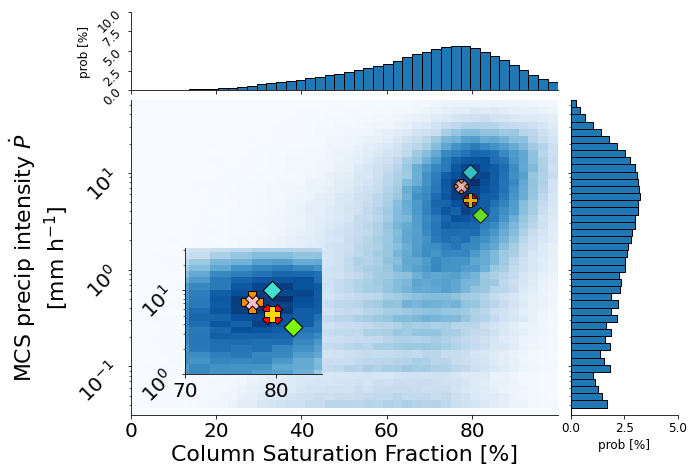

In [12]:
fig = plt.figure( figsize=(9.5, 7) )
font_size = 20
plt.rcParams.update({
    'font.size':font_size,
    'axes.labelsize':font_size+2,
    'xtick.labelsize':font_size,
    'ytick.labelsize':font_size,
    'legend.fontsize':font_size,
})
i = np.where( (~np.isnan(csf_ERAI)) & (~np.isnan(pmax_ERAI)) )

gs = fig.add_gridspec( 2, 2, width_ratios=(4, 1), height_ratios=(1, 4), left=0.1, right=0.9, bottom=0.1, top=0.9,
                     wspace=0.05, hspace=0.05 )
ax = fig.add_subplot(gs[1,0])
ax_histx = fig.add_subplot( gs[0,0], sharex=ax )
ax_histy = fig.add_subplot( gs[1,1], sharey=ax )
xbins = np.linspace( 0, 100, 45 )
ybins = np.logspace( -1.5, 1.75, 45 )
h = scatter_hist( csf_ERAI[i], pmax_ERAI[i], xbins, ybins, ax, ax_histx, ax_histy )

ax.set_xticks( [0, 20, 40, 60, 80] )
ax_histx.set_ylabel( 'prob [%]', fontsize=12 )
ax_histx.set_yticks( [0, 2.5, 5, 7.5, 10], rotation=45 )
ax_histy.set_xlabel( 'prob [%]', fontsize=12 )
ax_histy.set_xticks( [0, 2.5, 5], rotation=45 )
ax.set_ylabel( r'MCS precip intensity $\dot{P}$ '
              '\n'
              '[mm h$^{-1}$]' )
ax.set_xlabel( 'Column Saturation Fraction [%]' )

# Inset to see centroids more easily
left, bottom, width, height = [0.18, 0.18, 0.2, 0.25]
ax2 = fig.add_axes([left, bottom, width, height])
ax2.hist2d( csf_ERAI[i], pmax_ERAI[i], bins=(xbins, ybins), cmap=cm.Blues )
ax2.set_xlim( [70, 85] )
ax2.set_yscale( 'log' )
ax2.set_ylim( [1, 10**1.5] )

for a in ax, ax_histx, ax_histy, ax2:
    a.spines['top'].set_visible( False )
    a.spines['right'].set_visible( False )
    for t in a.get_yticklabels():
        t.set_rotation(45)

        
# Where is the center of mass of the joint distribution for young/old/big/small systems? 
# (The cells below must be run for this.)
h_csfpmax = [ h1, h4, h5, h7, h3, h6 ] #h2 - already covered by h4, h6 - already covered by h5
farbe = [ 'red', 'gold', 'darkorange', 'lawngreen', 'pink', 'turquoise' ]
forme = [ 'X', 'P', 'P', 'D', 'X', 'D']
grose = [ 150, 200, 200, 120, 150, 120 ]
increment = [ 250, 40, 250, 50, 50, 50 ]
for histo, f, s, z, ii in zip( h_csfpmax, farbe, forme, grose, increment ):
    l, m = unravel_index( histo[0].argmax(), histo[0].shape )
    #print(l,m)
    ax.scatter( xbins[l], ybins[m], marker=s, color=f, s=z, zorder=10, edgecolor='k', alpha=0.8 )
    ax2.scatter( xbins[l], ybins[m], marker=s, color=f, s=z+ii, zorder=10, edgecolor='k' )
    
plt.tight_layout()
fig.savefig( '/groups/sylvia/JAS-MCS-rain/figures/csf-precip-ERAI.pdf', bbox_inches='tight' )
plt.show()

### Joint distribution of CSF and MCS precip for short- and long-lived systems

In [8]:
i = np.where(lifetime_ERAI <= 2)
csf_ERAI_young = csf_ERAI[i]
pmax_ERAI_young = pmax_ERAI[i]
i = np.where( (~np.isnan(csf_ERAI_young)) & (~np.isnan(pmax_ERAI_young)) )
h1 = scatter_hist( csf_ERAI_young[i], pmax_ERAI_young[i], xbins, ybins, ax, ax_histx, ax_histy )

i = np.where((lifetime_ERAI <= 4) & (lifetime_ERAI > 2))
csf_ERAI_mid = csf_ERAI[i]
pmax_ERAI_mid = pmax_ERAI[i]
i = np.where( (~np.isnan(csf_ERAI_mid)) & (~np.isnan(pmax_ERAI_mid)) )
h2 = scatter_hist( csf_ERAI_mid[i], pmax_ERAI_mid[i], xbins, ybins, ax, ax_histx, ax_histy )

i = np.where((lifetime_ERAI > 3))
csf_ERAI_old = csf_ERAI[i]
pmax_ERAI_old = pmax_ERAI[i]
i = np.where( (~np.isnan(csf_ERAI_old)) & (~np.isnan(pmax_ERAI_old)) )
h3 = scatter_hist( csf_ERAI_old[i], pmax_ERAI_old[i], xbins, ybins, ax, ax_histx, ax_histy )

### Joint distribution of CSF and MCS precip filtering by morphology

In [9]:
i = np.where(maxrad_ERAI <= 150)
#print(len(i[0]))
csf_ERAI_small = csf_ERAI[i]
pmax_ERAI_small = pmax_ERAI[i]
i = np.where( (~np.isnan(csf_ERAI_small)) & (~np.isnan(pmax_ERAI_small)) )
h4 = scatter_hist( csf_ERAI_small[i], pmax_ERAI_small[i], xbins, ybins, ax, ax_histx, ax_histy )

i = np.where(maxrad_ERAI > 400)
#print(len(i[0]))
csf_ERAI_big = csf_ERAI[i]
pmax_ERAI_big = pmax_ERAI[i]
i = np.where( (~np.isnan(csf_ERAI_big)) & (~np.isnan(pmax_ERAI_big)) )
h5 = scatter_hist( csf_ERAI_big[i], pmax_ERAI_big[i], xbins, ybins, ax, ax_histx, ax_histy )

i = np.where(minctt_ERAI <= 190)
print(len(i[0]))
csf_ERAI_deep = csf_ERAI[i]
pmax_ERAI_deep = pmax_ERAI[i]
i = np.where( (~np.isnan(csf_ERAI_deep)) & (~np.isnan(pmax_ERAI_deep)) )
h6 = scatter_hist( csf_ERAI_deep[i], pmax_ERAI_deep[i], xbins, ybins, ax, ax_histx, ax_histy )

i = np.where(minctt_ERAI > 205)
print(len(i[0]))
csf_ERAI_shallow = csf_ERAI[i]
pmax_ERAI_shallow = pmax_ERAI[i]
i = np.where( (~np.isnan(csf_ERAI_shallow)) & (~np.isnan(pmax_ERAI_shallow)) )
h7 = scatter_hist( csf_ERAI_shallow[i], pmax_ERAI_shallow[i], xbins, ybins, ax, ax_histx, ax_histy )

267761
98191


### Joint distribution of CSF and MCS precip accumulation

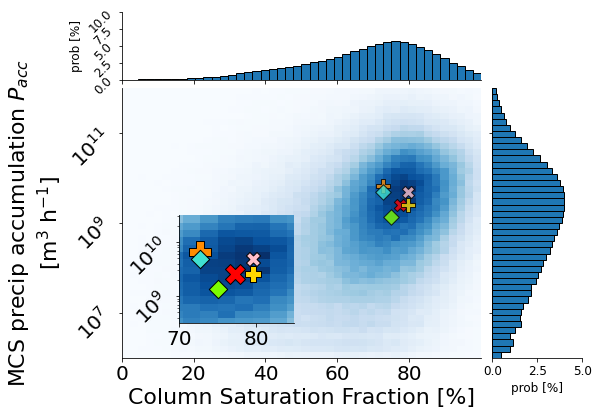

In [16]:
fig = plt.figure( figsize=(8,6) )
font_size = 20
plt.rcParams.update({
    'font.size':font_size,
    'axes.labelsize':font_size+2,
    'xtick.labelsize':font_size,
    'ytick.labelsize':font_size,
    'legend.fontsize':font_size,
})
i = np.where( (~np.isnan(csf_ERAI)) & (~np.isnan(pacc_ERAI)) )

gs = fig.add_gridspec( 2, 2, width_ratios=(4, 1), height_ratios=(1, 4), left=0.1, right=0.9, bottom=0.1, top=0.9,
                     wspace=0.05, hspace=0.05 )
ax = fig.add_subplot(gs[1,0])
ax_histx = fig.add_subplot( gs[0,0], sharex=ax )
ax_histy = fig.add_subplot( gs[1,1], sharey=ax )
xbins = np.linspace(0,100,45)
ybins = np.logspace(6,12,45)
scatter_hist( csf_ERAI[i], pacc_ERAI[i], xbins, ybins, ax, ax_histx, ax_histy )

ax.set_xticks( [0, 20, 40, 60, 80] )
ax_histx.set_ylabel( 'prob [%]', fontsize=12 )
ax_histx.set_yticks( [0, 2.5, 5, 7.5, 10], rotation=45 )
ax_histy.set_xlabel( 'prob [%]', fontsize=12 )
ax_histy.set_xticks( [0, 2.5, 5], rotation=45 )
ax.set_ylabel( 'MCS precip accumulation $P_{acc}$'
              '\n'
              '[m$^3$ h$^{-1}$]' )
ax.set_xlabel( 'Column Saturation Fraction [%]' )

# Inset to see centroids more easily
left, bottom, width, height = [0.2, 0.18, 0.2, 0.25]
ax2 = fig.add_axes([left, bottom, width, height])
ax2.hist2d( csf_ERAI[i], pacc_ERAI[i], bins=(xbins, ybins), cmap=cm.Blues )
ax2.set_xlim( [70, 85] )
ax2.set_yscale( 'log' )
ax2.set_ylim( [10**8.5, 10**10.5]  )

for a in ax, ax_histx, ax_histy, ax2:
    a.spines['top'].set_visible( False )
    a.spines['right'].set_visible( False )
    for t in a.get_yticklabels():
        t.set_rotation(45)
        
# Where is the center of mass of the joint distribution for young/old/big/small systems? 
# (The cells below must be run for this.)
h_csfpacc = [ h1, h4, h5, h7, h3, h6 ] #h2 - already covered by h4, h6 - already covered by h5
farbe = [ 'red', 'gold', 'darkorange', 'lawngreen', 'pink', 'turquoise' ]
forme = [ 'X', 'P', 'P', 'D', 'X', 'D']
grose = [ 150, 200, 200, 120, 150, 120 ]
increment = [ 250, 40, 250, 50, 50, 50 ]
for histo, f, s, z, ii in zip( h_csfpacc, farbe, forme, grose, increment ):
    l, m = unravel_index( histo[0].argmax(), histo[0].shape )
    #print(l,m)
    ax.scatter( xbins[l], ybins[m], marker=s, color=f, s=z, zorder=10, edgecolor='k', alpha=0.8 )
    ax2.scatter( xbins[l], ybins[m], marker=s, color=f, s=z+ii, zorder=10, edgecolor='k' )
        
plt.tight_layout()
#fig.savefig( '/groups/sylvia/JAS-MCS-rain/figures/csf-pacc-ERAI.pdf', bbox_inches='tight' )
plt.show()

### Joint distribution of CSF and MCS precip accumulation for short- and long-lived systems

In [14]:
i = np.where(lifetime_ERAI <= 10)
csf_ERAI_young = csf_ERAI[i]
pacc_ERAI_young = pacc_ERAI[i]
i = np.where( (~np.isnan(csf_ERAI_young)) & (~np.isnan(pacc_ERAI_young)) )
h1 = scatter_hist( csf_ERAI_young[i], pacc_ERAI_young[i], xbins, ybins, ax, ax_histx, ax_histy )
print(h1[0].argmax())
print( unravel_index( h1[0].argmax(), h1[0].shape ) )

i = np.where((lifetime_ERAI <= 4) & (lifetime_ERAI > 2))
csf_ERAI_mid = csf_ERAI[i]
pacc_ERAI_mid = pacc_ERAI[i]
i = np.where( (~np.isnan(csf_ERAI_mid)) & (~np.isnan(pacc_ERAI_mid)) )
h2 = scatter_hist( csf_ERAI_mid[i], pacc_ERAI_mid[i], xbins, ybins, ax, ax_histx, ax_histy )

i = np.where((lifetime_ERAI > 3))
csf_ERAI_old = csf_ERAI[i]
pacc_ERAI_old = pacc_ERAI[i]
i = np.where( (~np.isnan(csf_ERAI_old)) & (~np.isnan(pacc_ERAI_old)) )
h3 = scatter_hist( csf_ERAI_old[i], pacc_ERAI_old[i], xbins, ybins, ax, ax_histx, ax_histy )
print(h3[0].argmax())
print( unravel_index( h3[0].argmax(), h3[0].shape ) )

1521
(34, 25)
1567
(35, 27)


### Joint distribution of CSF and MCS precip filtering by morphology

In [15]:
i = np.where(maxrad_ERAI <= 150)
#print(len(i[0]))
csf_ERAI_small = csf_ERAI[i]
pacc_ERAI_small = pacc_ERAI[i]
i = np.where( (~np.isnan(csf_ERAI_small)) & (~np.isnan(pacc_ERAI_small)) )
h4 = scatter_hist( csf_ERAI_small[i], pacc_ERAI_small[i], xbins, ybins, ax, ax_histx, ax_histy )

i = np.where(maxrad_ERAI > 400)
#print(len(i[0]))
csf_ERAI_big = csf_ERAI[i]
pacc_ERAI_big = pacc_ERAI[i]
i = np.where( (~np.isnan(csf_ERAI_big)) & (~np.isnan(pacc_ERAI_big)) )
h5 = scatter_hist( csf_ERAI_big[i], pacc_ERAI_big[i], xbins, ybins, ax, ax_histx, ax_histy )

i = np.where(minctt_ERAI <= 190)
#print(len(i[0]))
csf_ERAI_deep = csf_ERAI[i]
pacc_ERAI_deep = pacc_ERAI[i]
i = np.where( (~np.isnan(csf_ERAI_deep)) & (~np.isnan(pacc_ERAI_deep)) )
h6 = scatter_hist( csf_ERAI_deep[i], pacc_ERAI_deep[i], xbins, ybins, ax, ax_histx, ax_histy )

i = np.where(minctt_ERAI > 205)
#print(len(i[0]))
csf_ERAI_shallow = csf_ERAI[i]
pacc_ERAI_shallow = pacc_ERAI[i]
i = np.where( (~np.isnan(csf_ERAI_shallow)) & (~np.isnan(pacc_ERAI_shallow)) )
h7 = scatter_hist( csf_ERAI_shallow[i], pacc_ERAI_shallow[i], xbins, ybins, ax, ax_histx, ax_histy )